In [4]:
pip install torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Load and Preprocess the MNIST Dataset

In [6]:
# Define image transformations: Convert to tensor & normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values (-1 to 1 range)
])

# Load training and test datasets
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset info
print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


100%|██████████| 9.91M/9.91M [00:13<00:00, 717kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 80.0kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 994kB/s] 
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


Training samples: 60000, Test samples: 10000


# Define the CNN Model

In [9]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # Output: 28x28x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: 28x28x64
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 14x14x64

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Flattened input size
        self.fc2 = nn.Linear(128, 10)  # Output layer (10 classes)
        
        # Activation & Dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = x.view(-1, 64 * 7 * 7)  # Flatten before fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))  # FC1 -> ReLU -> Dropout
        x = self.fc2(x)  # Output layer (no activation, handled in loss function)
        return x

# Initialize model
model = DigitClassifier()
print(model)

DigitClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


# Define Loss Function and Optimizer

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function (CrossEntropyLoss for classification tasks)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam with learning rate 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Model

In [11]:
num_epochs = 5  # Increase for better accuracy

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available

        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete!")

Epoch [1/5], Loss: 0.1827
Epoch [2/5], Loss: 0.0582
Epoch [3/5], Loss: 0.0420
Epoch [4/5], Loss: 0.0325
Epoch [5/5], Loss: 0.0269
Training complete!


# Evaluate the Model

In [12]:
# Switch model to evaluation mode
model.eval()

correct = 0
total = 0

with torch.no_grad():  # No gradient computation needed for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 99.12%


# Test on a Sample Image

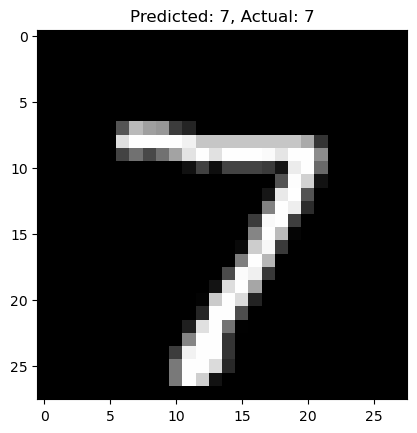

In [13]:
# Get a random test image
image, label = test_dataset[0]
image = image.unsqueeze(0).to(device)  # Add batch dimension

# Predict
output = model(image)
_, predicted = torch.max(output, 1)

# Display image with prediction
plt.imshow(image.cpu().squeeze(), cmap="gray")
plt.title(f"Predicted: {predicted.item()}, Actual: {label}")
plt.show()